SA on game comments

model: GloVe + CNN (or BiLSTM whatsoever??)

The training script to run (as training this is fast)

---

Load the pre-sampled dataset

In [1]:
# load the pre-sampled dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime


# set some parameters of this training
DATASET_LIST = [120, 240, 480]
DATASET_LIST_INDEX = 0
DATASET_IS_BALANCED = True


dataset_folder_path = Path(f'../../dataset/sa/sampled_{DATASET_LIST[DATASET_LIST_INDEX]}k_2023-12-16/')
dataset_valid_folder_path = Path('../../dataset/sa/sampled_valid_2023-12-16/')

dataset_val_bal = pd.read_pickle(dataset_valid_folder_path / 'validation_balanced.pkl')
dataset_val_imbal = pd.read_pickle(dataset_valid_folder_path / 'validation_imbalanced.pkl')

if DATASET_IS_BALANCED:
    dataset_traintest = pd.read_pickle(dataset_folder_path / f'dataset_bal_sampled_{DATASET_LIST[DATASET_LIST_INDEX]}k.pkl')
else:
    dataset_traintest = pd.read_pickle(dataset_folder_path / f'dataset_imbal_sampled_{DATASET_LIST[DATASET_LIST_INDEX]}k.pkl')

In [2]:
dataset_val_bal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301344 entries, 2447379 to 2758277
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         301344 non-null  int64 
 1   app_id        301344 non-null  int64 
 2   app_name      301344 non-null  object
 3   review_text   301344 non-null  object
 4   review_score  301344 non-null  int64 
 5   review_votes  301344 non-null  int64 
 6   num_of_words  301344 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 18.4+ MB


In [3]:
temp = dataset_val_bal.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,150672
1,1,150672


In [4]:
dataset_val_imbal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 925305 entries, 1752495 to 4683282
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         925305 non-null  int64 
 1   app_id        925305 non-null  int64 
 2   app_name      925305 non-null  object
 3   review_text   925305 non-null  object
 4   review_score  925305 non-null  int64 
 5   review_votes  925305 non-null  int64 
 6   num_of_words  925305 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 56.5+ MB


In [5]:
temp = dataset_val_imbal.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,150928
1,1,774377


In [6]:
dataset_traintest.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 3758070 to 3855230
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         120000 non-null  int64 
 1   app_id        120000 non-null  int64 
 2   app_name      120000 non-null  object
 3   review_text   120000 non-null  object
 4   review_score  120000 non-null  int64 
 5   review_votes  120000 non-null  int64 
 6   num_of_words  120000 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 7.3+ MB


In [7]:
temp = dataset_traintest.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,60000
1,1,60000


---

In [8]:
X_imbal_valid = dataset_val_imbal['review_text']
y_imbal_valid = dataset_val_imbal['review_score']

X_bal_valid = dataset_val_bal['review_text']
y_bal_valid = dataset_val_bal['review_score']

---

Any data augmentation plz add here

In [9]:
# TODO: add data augmentation here

---

Create training and testing dataset from here :D

baseline (imbalanced): positive comments : negative comments = 5:1

baseline (balanced): positive comments : negative comments = 1:1

In [10]:
# define constants

TEST_RATIO = 0.1            # ratio of test set to the whole train-test dataset

In [11]:
X_train_test = dataset_traintest['review_text']
y_train_test = dataset_traintest['review_score']

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_train_test,
    y_train_test,
    random_state=13,
    test_size=TEST_RATIO)

In [13]:
print('Training set')
print(len(X_train))
print(len(y_train))
print()
print('Test set')
print(len(X_test))
print(len(y_test))
print()
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Training set')
print(pd.Series(y_train).value_counts())
print()
print('Test set')
print(pd.Series(y_test).value_counts())
print()
print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('training set datatype')
print(type(X_train))
print(type(y_train))
print()
print('test set datatype')
print(type(X_test))
print(type(y_test))
print()
print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Training set
108000
108000

Test set
12000
12000

Validation (imbalanced) set
925305
925305

Validation (balanced) set
301344
301344


Training set
review_score
0    54060
1    53940
Name: count, dtype: int64

Test set
review_score
1    6060
0    5940
Name: count, dtype: int64

Validation (imbalanced) set
review_score
1    774377
0    150928
Name: count, dtype: int64

Validation (balanced) set
review_score
0    150672
1    150672
Name: count, dtype: int64


training set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

test set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

validation (imbalanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

validation (balanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


---

Sanity check

In [14]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

print()
print()

# distribution of +ve and -ve comments in train and test set
import collections

print('training set')
print(collections.Counter(y_train))
print('pos / neg ratio =', float(collections.Counter(y_train)[1] / collections.Counter(y_train)[0]))
print()
print('testing set')
print(collections.Counter(y_test))
print('pos / neg ratio =', float(collections.Counter(y_test)[1] / collections.Counter(y_test)[0]))

108000
108000
12000
12000


training set
Counter({0: 54060, 1: 53940})
pos / neg ratio = 0.9977802441731409

testing set
Counter({1: 6060, 0: 5940})
pos / neg ratio = 1.02020202020202


---

Data cleaning

This is customized to each model, as each model has their own limitation to the dataset

No rows will be removed in this step

In [15]:
import sys
 
# setting path
sys.path.append('../')

import str_cleaning_functions

# define your own cleaning function

def cleaning_arr(str_arr):
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_num(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_symbols(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_punctuation(x))
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_stopword(x))      # no need to remove stopwords, as previous study shown including stopwords can improve performance (https://aclanthology.org/P12-1092.pdf)
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.stemming(x))


    return str_arr

In [16]:
X_train = cleaning_arr(X_train)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [17]:
X_test = cleaning_arr(X_test)
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [18]:
# check shapes

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(108000,)
(108000,)

(12000,)
(12000,)


---

Training phrase

Create tf dataset object for efficient loading during training

In [19]:
class_names = np.unique(y_train)
print(class_names)

[0 1]


In [20]:
# build training output folder (storing the models)

# max_tokens for TextVectorization layer
# max_tokens shd be equal to that in tfidf (for fair comparison)
MAX_TOKENS = 20000

training_name = 'glove-cnn-{}_{}k_{}'.format(
    MAX_TOKENS,
    DATASET_LIST[DATASET_LIST_INDEX],
    'bal' if DATASET_IS_BALANCED else 'imbal')

training_date = datetime.today()

training_output_folder = Path(f'{training_name}/').resolve()

if not training_output_folder.exists():
    training_output_folder.mkdir(parents=True, exist_ok=False)

In [21]:
# convert X_valid and y_valid to numpy array first

# X_valid = X_valid.to_numpy()
# y_valid = y_valid.to_numpy()

In [22]:
import tensorflow as tf

# create a tensorflow dataset object

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

2023-12-18 23:11:11.302611: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-18 23:11:11.302650: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-18 23:11:11.302657: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-18 23:11:11.302709: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-18 23:11:11.302738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
# batch datasets

BATCH_SIZE = 128

train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
# valid_dataset = valid_dataset.batch(BATCH_SIZE)

In [24]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {label[0]}")
    print()

Abstract: b'doesn t really work its impossible to save your data'
Label(s): 0

Abstract: b'one of the best atmospheres i ve seen in a game while the ending was a bit rushed the rest of the game is a soldi '
Label(s): 1

Abstract: b'microtransactions in a game'
Label(s): 0

Abstract: b'still as frantic still as gut wrenching still as fun playing as clem puts a whole new spin on things and adds to the palpable sense of dread'
Label(s): 1

Abstract: b'great for actual tuts on gun disassembly'
Label(s): 1



Create a vocabulary index

Let's use the TextVectorization to index the vocabulary found in the dataset. Later, we'll use the same layer instance to vectorize the samples.

Our layer will only consider the top N words, and will truncate or pad sequences to be actually 200 tokens long.

In [25]:
# import tensorflow as tf
# from tensorflow.keras.layers import TextVectorization

vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,              # same as TFIDF-RF one
    output_sequence_length=512)         # same as BERT
# text_ds = tf.data.Dataset.from_tensor_slices(X_train_subset)
vectorizer.adapt(train_dataset.map(lambda text, label: text))

2023-12-18 23:11:11.745974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [26]:
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'to', 'a', 'game', 'i', 'it', 'of']

In [27]:
output = vectorizer([["the game looks awesome"]])
print(output.numpy()[0, :])
print(output.numpy().shape)

[  2   6 298 232   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

load pre-trained word embeddings

Download your own and save it under dev-workspace/sa/

In [28]:
glove_file_path = Path("../glove.6B/glove.6B.100d.txt").resolve()

embeddings_index = {}
with open(glove_file_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400001 word vectors.


Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. 

It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

In [29]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18091 words (1909 misses)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set trainable=False so as to keep the embeddings fixed (we don't want to update them during training).

In [30]:
import keras
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

Build the model

A simple 1D convnet with global max pooling and a classifier at the end.

In [31]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv1D(64, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)           # for multi-class probability output
# preds = layers.Dense(1, activation='sigmoid')(x)                             # for single-class output


In [32]:
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         38528     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                        

apply the vectorizer to transform the strings to indices

apply to all three datasets

In [33]:
train_dataset = train_dataset.map(lambda x, y: (vectorizer(x), y)).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (vectorizer(x), y)).prefetch(tf.data.AUTOTUNE)
# valid_dataset = valid_dataset.map(lambda x, y: (vectorizer(x), y)).prefetch(tf.data.AUTOTUNE)

In [34]:
for elem in train_dataset.as_numpy_iterator():
    if elem[0].shape[1] != 512:
        print('find one not equal with 512')
        print('its shape = ', elem[0].shape)
        print(elem)

In [35]:
tt = train_dataset.take(3).as_numpy_iterator()
for elem in tt:
    print(elem)
    print(elem[0].shape)
    print()
    break

(array([[  156,    19,    46, ...,     0,     0,     0],
       [   41,     9,     2, ...,     0,     0,     0],
       [  946,    13,     5, ...,     0,     0,     0],
       ...,
       [    7,   531,  1100, ...,     0,     0,     0],
       [    7,  1074, 10091, ...,     0,     0,     0],
       [   56,    20,    84, ...,     0,     0,     0]]), array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]))
(128, 512)



training

In [36]:
# copy from the cell above

# TODO: add more metrics
# examples
metrics = [
    keras.metrics.SparseCategoricalAccuracy(),
    # keras.metrics.FalseNegatives(name="fn", thresholds=0),
    # keras.metrics.FalsePositives(name="fp"),
    # keras.metrics.TrueNegatives(name="tn"),
    # keras.metrics.TruePositives(name="tp"),
    # keras.metrics.Precision(name="precision"),
    # keras.metrics.Recall(name="recall")
]

# using legacy optimizers because of compatability issue
# model.compile(
#     loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3), metrics=metrics
# )
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=metrics
)

# model.compile(
#     loss='binary_crossentropy', optimizer='rmsprop', weighted_metrics=metrics
# )

# apply early stopping to avoid overfit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)


# try to use weighted samples to avoid data imbalance
# so as the test
history_model = model.fit(
    train_dataset,
    epochs=20, 
    validation_data=test_dataset,
    callbacks=[callback]
)

Epoch 1/20


2023-12-18 23:11:20.155478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


844/844 [==============================] - 15s 17ms/step - loss: 0.4711 - sparse_categorical_accuracy: 0.7681 - val_loss: 0.4135 - val_sparse_categorical_accuracy: 0.8108
Epoch 2/20
844/844 [==============================] - 14s 17ms/step - loss: 0.3636 - sparse_categorical_accuracy: 0.8379 - val_loss: 0.4140 - val_sparse_categorical_accuracy: 0.8133
Epoch 3/20
844/844 [==============================] - 13s 15ms/step - loss: 0.3273 - sparse_categorical_accuracy: 0.8574 - val_loss: 0.3707 - val_sparse_categorical_accuracy: 0.8346
Epoch 4/20
844/844 [==============================] - 14s 16ms/step - loss: 0.3073 - sparse_categorical_accuracy: 0.8685 - val_loss: 0.4142 - val_sparse_categorical_accuracy: 0.8184
Epoch 5/20
844/844 [==============================] - 13s 16ms/step - loss: 0.3140 - sparse_categorical_accuracy: 0.8675 - val_loss: 0.4084 - val_sparse_categorical_accuracy: 0.8333
Epoch 6/20
844/844 [==============================] - 13s 15ms/step - loss: 0.3219 - sparse_categoric

In [37]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# func from: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

def plot_metrics(history):
  metrics = ['loss', 'sparse_categorical_accuracy']
  plt.style.use('seaborn-v0_8')
  # plt.style.use('seaborn-v0_8-dark')
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.title('Training metrics')
    plt.legend()

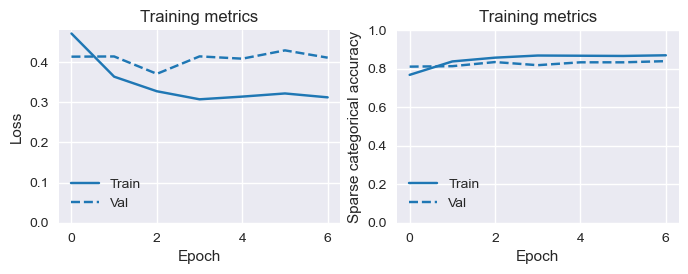

In [38]:
plot_metrics(history_model)

---

Save the model and training history (for reproduce the graph and test result)

In [39]:
import pickle

with open(Path.joinpath(training_output_folder, 'train-history_{}_{}/'.format(
    training_name,
    training_date.strftime("%Y-%m-%d"))), 'wb') as file_pi:
    
        pickle.dump(history_model.history, file_pi)

In [40]:
# load training history

from datetime import datetime
import pickle

with open(Path.joinpath(training_output_folder, 'train-history_{}_{}/'.format(
    training_name,
    training_date.strftime("%Y-%m-%d")
    )), 'rb') as file_pi:
        history_model_loaded = pickle.load(file_pi)

In [41]:
history_model_loaded

{'loss': [0.4711031913757324,
  0.3636130690574646,
  0.32733315229415894,
  0.30727943778038025,
  0.3140202760696411,
  0.3218517601490021,
  0.3121601641178131],
 'sparse_categorical_accuracy': [0.7680833339691162,
  0.8378888964653015,
  0.8574259281158447,
  0.8685463070869446,
  0.8674629330635071,
  0.8663055300712585,
  0.8697962760925293],
 'val_loss': [0.4134545922279358,
  0.4139760434627533,
  0.37072357535362244,
  0.41415783762931824,
  0.4084356725215912,
  0.4291172921657562,
  0.4109525978565216],
 'val_sparse_categorical_accuracy': [0.8108333349227905,
  0.8132500052452087,
  0.8345833420753479,
  0.8184166550636292,
  0.8333333134651184,
  0.8332499861717224,
  0.8394166827201843]}

In [42]:
# save text vectorizer

with open(Path.joinpath(training_output_folder, "{}_{}_textvectorizer.pkl".format(
                training_name,
                training_date.strftime("%Y-%m-%d"))
            ), 'wb') as f:
    

    pickle.dump({'config': vectorizer.get_config(),
                'weights': vectorizer.get_weights()}
                , f)

---

In [43]:
# load text vectorizer

from_disk = pickle.load(open(Path.joinpath(
    training_output_folder,
    "{}_{}_textvectorizer.pkl".format(
                training_name,
                training_date.strftime("%Y-%m-%d"))
            ), "rb"))

vectorizer_loaded = tf.keras.layers.TextVectorization(
    max_tokens=20000, 
    output_sequence_length=512)

vectorizer_loaded.set_weights(from_disk['weights'])

In [44]:
output2 = vectorizer_loaded([["the game looks awesome"]])
print(output2.numpy()[0, :])
print(output2.numpy().shape)

[  2   6 298 232   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [45]:
# save the model itself

model.save(Path.joinpath(
    training_output_folder,
    '{}_{}_model.keras'.format(
        training_name,
        training_date.strftime("%Y-%m-%d"))
    ))

In [46]:
# load the model itself

model_loaded = keras.models.load_model(Path.joinpath(
    training_output_folder,
    '{}_{}_model.keras'.format(
        training_name,
        training_date.strftime("%Y-%m-%d")
    )
))

In [47]:
model_loaded.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         38528     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                        

---

Save the model (a end2end pipeline for single string)

In [48]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

In [49]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer_loaded(string_input)
preds = model_loaded(x)
end_to_end_model = keras.Model(string_input, preds)

In [50]:
# positive reviews
# the third one is an actual postitive review from AC6
# https://steamcommunity.com/id/bromancedance/recommended/1888160/

probabilities = end_to_end_model.predict(
    [["The game deserves a game of the year"], ["I enjoy playing it very much"], ["Fun, FUN, FUN!!!!!! Souls is one of my favorite series of all time, but never tried an AC game before this one. This game is the most fun I've had in a game in so long. Not just the high points, but the pacing just keeps you in the fun seat CONSTANTLY. After playing Starfield and Baldurs Gate 3 recently it felt ILLEGAL how often I was having a blast. I was constantly ready for the point of the game where the fun would slow down, but it only ramps up. TRULY a breath of fresh air in todays gaming climate."]]
)

for prob in probabilities:
    print('output:', prob, '; class:', np.argmax(prob))

1/1 [==============================] - 0s 127ms/step
output: [0.01008886 0.98991114] ; class: 1
output: [0.03072691 0.9692731 ] ; class: 1
output: [0.0010852  0.99891484] ; class: 1


In [51]:
# negative reviews
# the second one: https://steamcommunity.com/id/x-pert_bandit/recommended/1091500/
# the third one: https://steamcommunity.com/profiles/76561197960511970/recommended/1716740/

probabilities = end_to_end_model.predict(
    [["Buying this game is wasting my money."], ["Now before all else is said, it is a good game, if it wasn't I wouldn't have put in so many hours elsewise. But save your cash until they've fixed a majority of the bugs and optimized it a bit more."], ["It is not a bad game. If you want Fallout in Space with dogfights, it absolutely delivers that. But the problems are that it feels very dated. The voice-acting and writing are embarrassingly bad, especially after coming off Baldurs Gate 3 where I found myself caring deeply about the characters and their stories. Starfield makes me want to skip dialog as fast as possible because it is so cringey. The main plot is about as cliched and uninspired as you can imagine. You are a no-name miner, but suddenly you are the crux of the whole plot and everyone just decides to make you the chosen one to do all the important stuff in a pre-existing group for no reason at all. It makes absolutely no sense when they had someone in their organization who had already experienced the mcguffin. The more I play it, the less I like it from the plot perspective. If people aren't playing for the plot, their experience will likely be better, but I still find the game feeling dated... Looks like I've played too much to refund it, which is disappointing, but the same issues still remain. The writing and voice-acting are reminiscent of a game from 1995 and really hold this game back."]]
)

for prob in probabilities:
    print('output:', prob, '; class:', np.argmax(prob))

1/1 [==============================] - 0s 24ms/step
output: [0.98616886 0.01383105] ; class: 0
output: [0.9274594  0.07254054] ; class: 0
output: [0.96070766 0.03929233] ; class: 0


In [52]:
from datetime import datetime

end_to_end_model.save(Path.joinpath(
    training_output_folder,
    '{}_{}_end2end.keras'.format(
        training_name,
        training_date.strftime("%Y-%m-%d"))
))

In [53]:
# load end to end model

end_to_end_model_loaded = keras.models.load_model(Path.joinpath(
    training_output_folder,
    '{}_{}_end2end.keras'.format(
        training_name,
        training_date.strftime("%Y-%m-%d"))
))

end_to_end_model_loaded.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 512)               0         
 Vectorization)                                                  
                                                                 
 model (Functional)          (None, 2)                 2166090   
                                                                 
Total params: 2166090 (8.26 MB)
Trainable params: 165890 (648.01 KB)
Non-trainable params: 2000200 (7.63 MB)
_________________________________________________________________


---

Evaluation on test set

In [54]:
y_test_pred_rawprob = model.predict(test_dataset)

94/94 [==============================] - 1s 6ms/step


In [55]:
print(y_test_pred_rawprob)
print()
print(y_test_pred_rawprob.shape)

[[0.7320408  0.26795918]
 [0.70025545 0.29974452]
 [0.01084961 0.98915046]
 ...
 [0.01223853 0.9877615 ]
 [0.99257576 0.00742429]
 [0.6310296  0.36897045]]

(12000, 2)


In [56]:
# since the output is a probability instead of a single label
# we need to convert that to a single 0 or 1 class
y_test_pred = np.argmax(y_test_pred_rawprob, axis=1)

# creating single class label probability for ploting ROC curve
y_test_pred_prob =  y_test_pred_rawprob if len(np.unique(y_test)) > 2 \
                    else np.array([y_test_pred_rawprob[i, pred] for i, pred in enumerate(list(y_test_pred))])

In [57]:
print(y_test_pred)
print(y_test_pred.shape)
print()
print(y_test_pred_prob)
print(y_test_pred_prob.shape)

[0 0 1 ... 1 0 0]
(12000,)

[0.7320408  0.70025545 0.98915046 ... 0.9877615  0.99257576 0.6310296 ]
(12000,)


In [58]:
test_result = model.evaluate(test_dataset, verbose=0)

for name, value in zip(model.metrics_names, test_result):
    print('{}: {}'.format(name, value))

loss: 0.4109525978565216
sparse_categorical_accuracy: 0.8394166827201843


In [59]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

def print_classification_report(y_true,y_pred):
    cfmat = confusion_matrix(y_true,y_pred)
    print('Classification report: \n',classification_report(y_true,y_pred))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[0,0]))
    print('FN - False Negative {}'.format(cfmat[1,0]))
    print('TP - True Positive {}'.format(cfmat[1,1]))
    print('FP - False Positive {}'.format(cfmat[0,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_true, y_pred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_true,y_pred)))

In [60]:
print_classification_report(y_test, y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      5940
           1       0.87      0.80      0.83      6060

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000



TN - True Negative 5243
FN - False Negative 1230
TP - True Positive 4830
FP - False Positive 697
Accuracy Rate: 0.8394166666666667
Misclassification Rate: 0.16058333333333333
F1-Score: 0.8392262290184546
ROC-AUC 0.8398448178151149


In [61]:
def create_confusion_matrix_graph(y_true, y_pred, title=None, save=False, save_filename=None):

    # pre checking
    if save and save_filename == None:
        print("save_filename camnot be empty, function exits.")
        return

    
    ax = sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt='')

    ax.set_title(title)
    ax.set_xlabel("predicted label")
    ax.set_ylabel('true label')
    ax.set_xticklabels(['[0]\nNegative', '[1]\nPositive'])
    ax.set_yticklabels(['Negative [0]', 'Positive [1]'])

    if save:
        plt.savefig(save_filename, dpi=600, faccecolor='w')

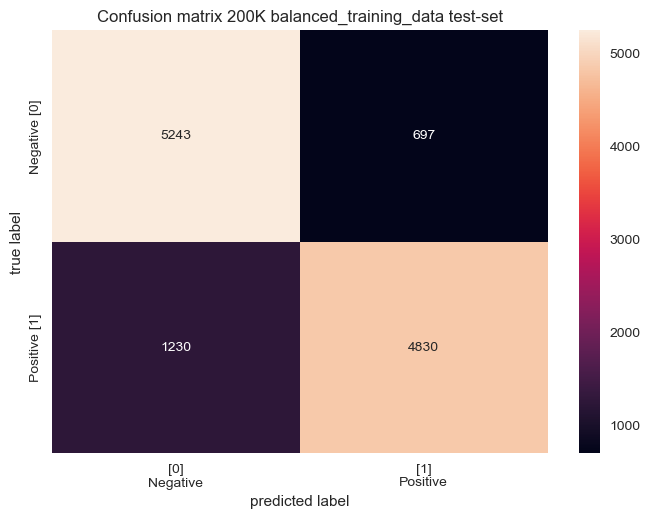

In [62]:
create_confusion_matrix_graph(y_test, y_test_pred, 'Confusion matrix 200K balanced_training_data test-set', False)

In [63]:
# plot ROC curve for binary class classification

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve_binary(y_test, y_pred, title=None, save=False, save_filename=None):

    # pre-checking
    if save and save_filename == None:
        print('save_filename cannot be empty. Function exits.')
        return


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print(roc_auc_score(y_test, y_pred))
    plt.figure(dpi=600)
    plt.plot(fpr[1], tpr[1], label="ROC curve (area = {:0.4f})".format(roc_auc_score(y_test, y_pred)))

    # random-guess line
    plt.plot([0, 1], [0, 1], "k--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title if title else 'Receiver operating characteristic (ROC)')
    plt.legend(loc='lower right')

    # if save:
    #     plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_ROC-curve_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

    # plt.show() should come AFTER than plt.savefig
    # as plt.show() clears the whole thing -> anything after wards will happen on a new blank figure
    plt.show()

0.4312549171583825


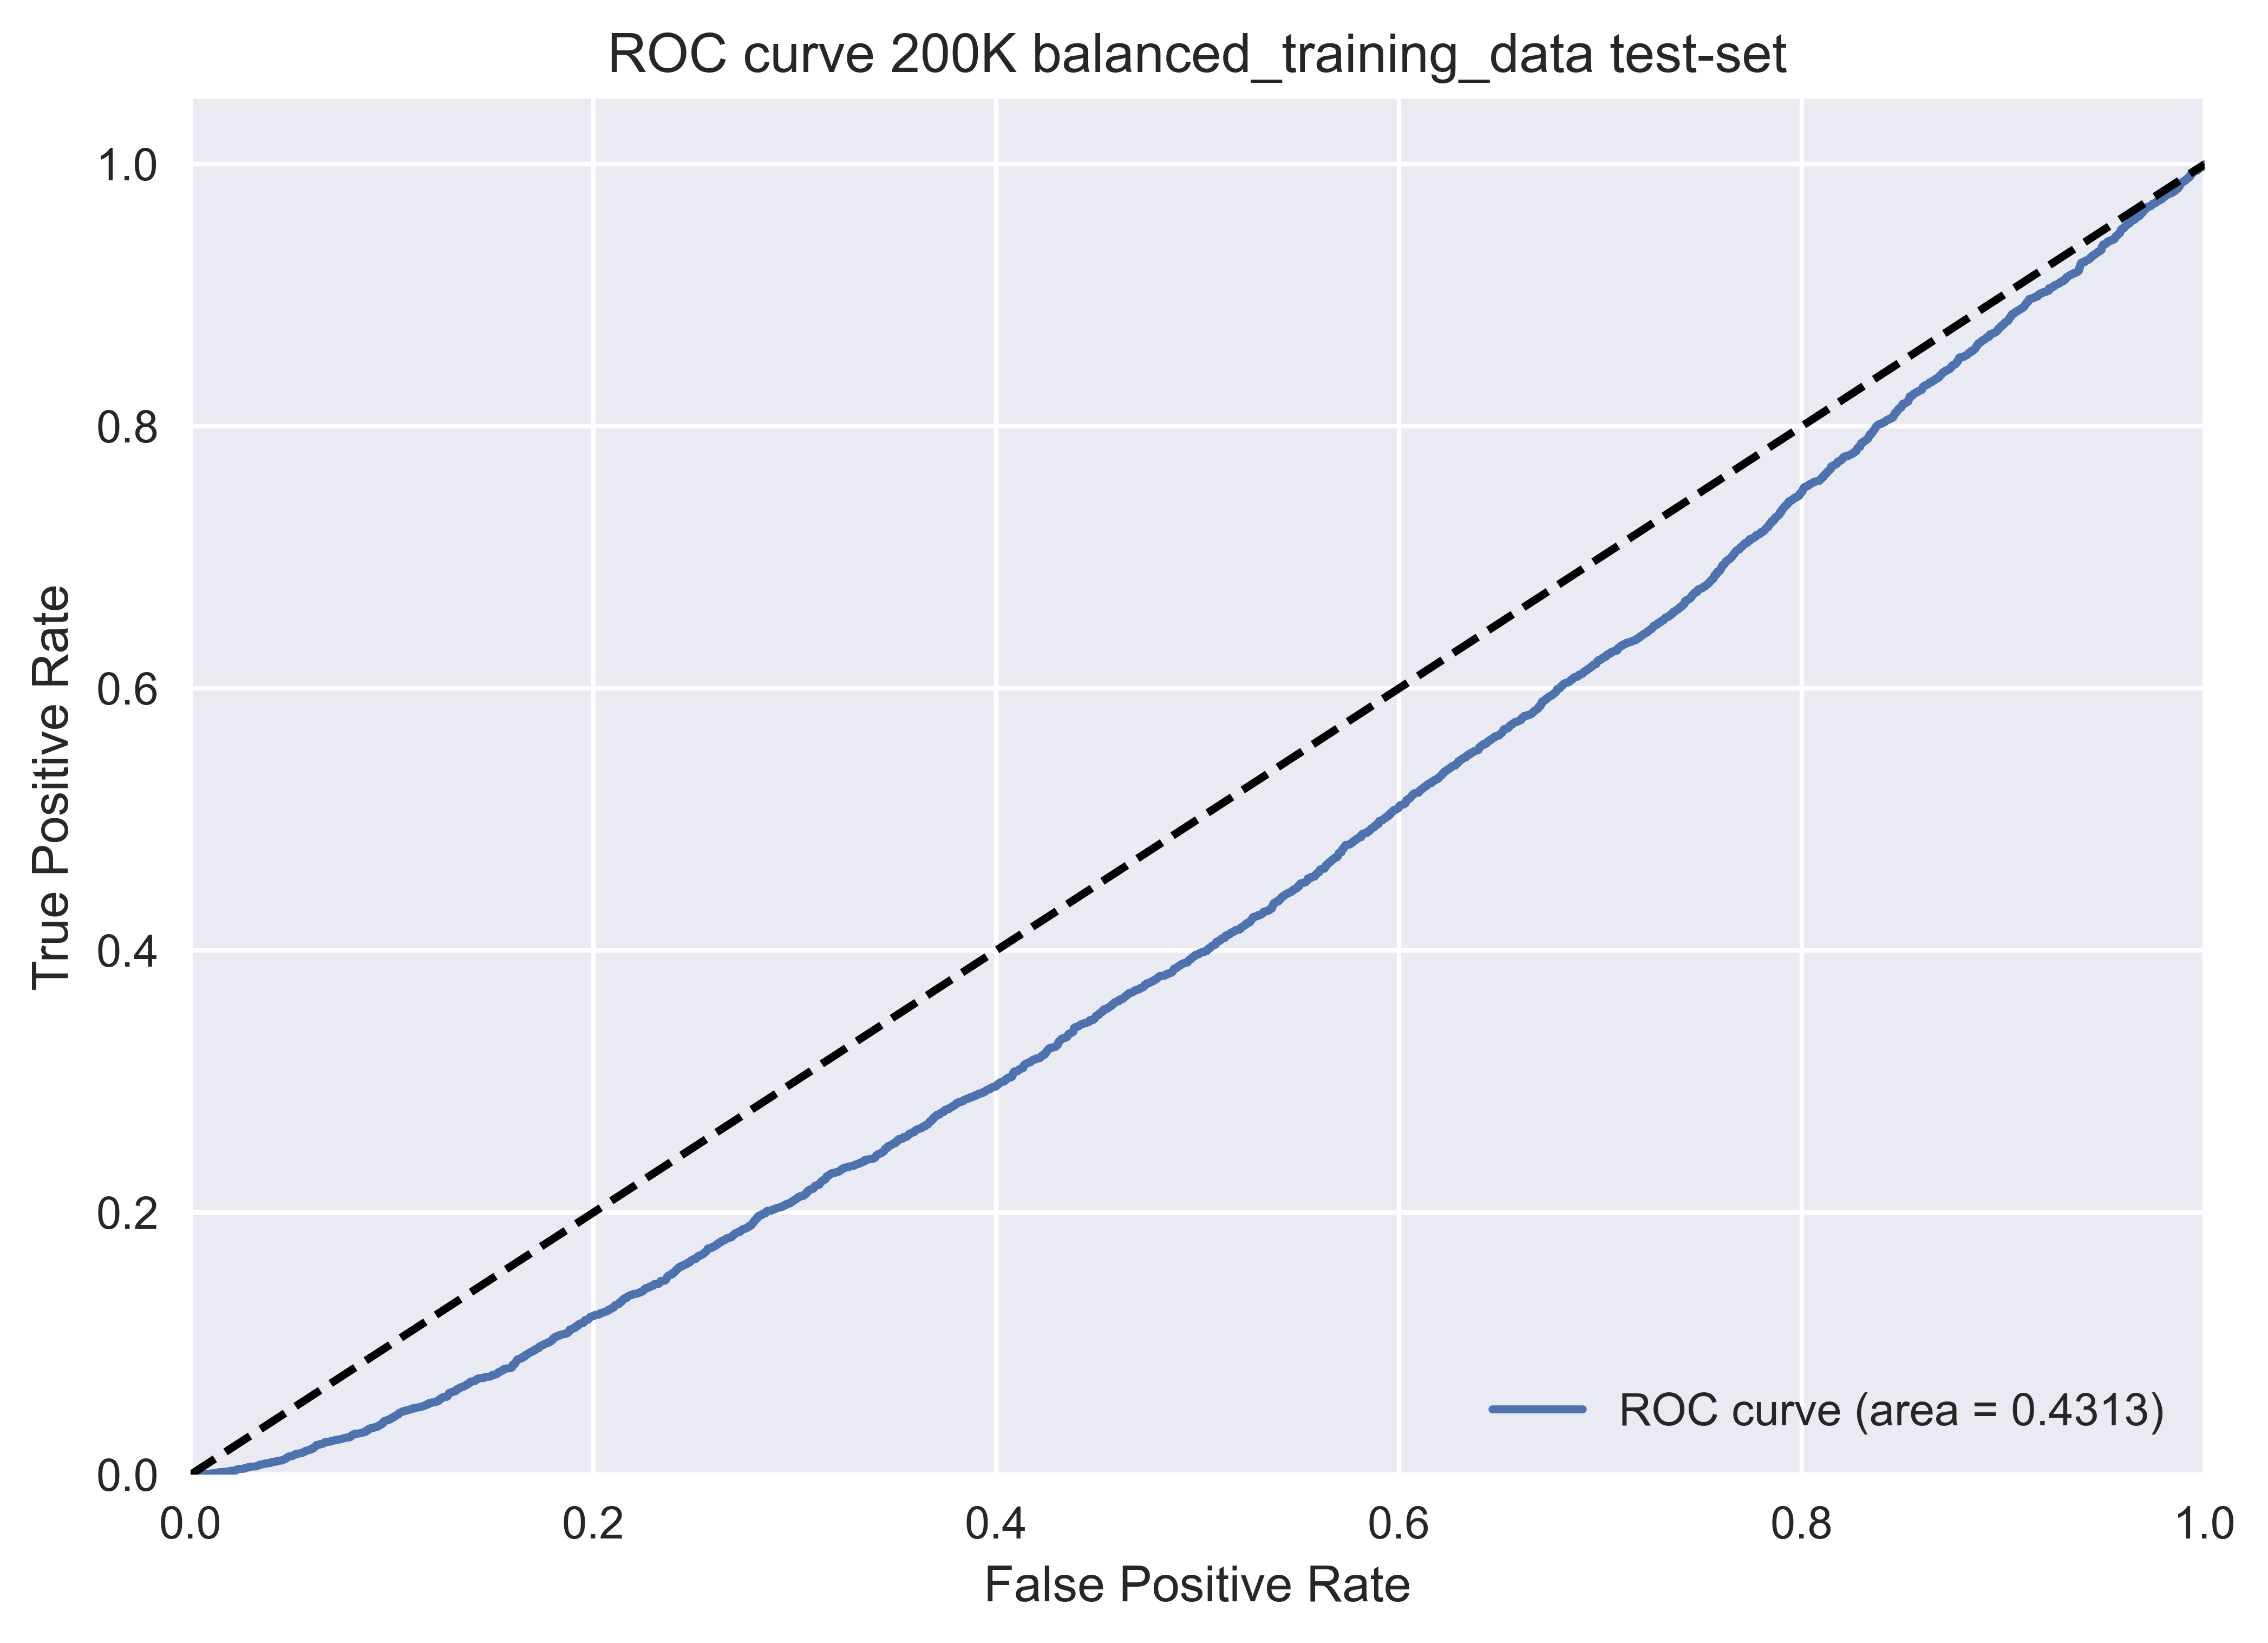

In [64]:
plot_roc_curve_binary(y_test, y_test_pred_prob, title='ROC curve 200K balanced_training_data test-set', save=False)

Evaluation on validation sets

first imbalanced set

then balanced set

In [65]:
X_imbal_valid = cleaning_arr(X_imbal_valid)
X_imbal_valid = X_imbal_valid.to_numpy()
y_imbal_valid = y_imbal_valid.to_numpy()

X_bal_valid = cleaning_arr(X_bal_valid)
X_bal_valid = X_bal_valid.to_numpy()
y_bal_valid = y_bal_valid.to_numpy()

In [66]:
# dataset formation

valid_imbal_dataset = tf.data.Dataset.from_tensor_slices((X_imbal_valid, y_imbal_valid))
valid_bal_dataset = tf.data.Dataset.from_tensor_slices((X_bal_valid, y_bal_valid))

valid_imbal_dataset = valid_imbal_dataset.batch(BATCH_SIZE)
valid_bal_dataset = valid_bal_dataset.batch(BATCH_SIZE)

In [67]:
# pass the loaded tokenizer

valid_imbal_dataset = valid_imbal_dataset.map(lambda x, y: (vectorizer_loaded(x), y)).prefetch(tf.data.AUTOTUNE)
valid_bal_dataset = valid_bal_dataset.map(lambda x, y: (vectorizer_loaded(x), y)).prefetch(tf.data.AUTOTUNE)

on fixed imbalanced validation set

In [68]:
y_imbal_valid_pred_prob_raw = model_loaded.predict(valid_imbal_dataset)

y_imbal_valid_pred = np.argmax(y_imbal_valid_pred_prob_raw, axis=1)

y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])

7229/7229 [==============================] - 37s 5ms/step


In [69]:
print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.46      0.88      0.61    150928
           1       0.97      0.80      0.88    774377

    accuracy                           0.81    925305
   macro avg       0.72      0.84      0.74    925305
weighted avg       0.89      0.81      0.83    925305



TN - True Negative 133427
FN - False Negative 155147
TP - True Positive 619230
FP - False Positive 17501
Accuracy Rate: 0.8134150361232242
Misclassification Rate: 0.18658496387677576
F1-Score: 0.7424121638011525
ROC-AUC 0.8418466569677083


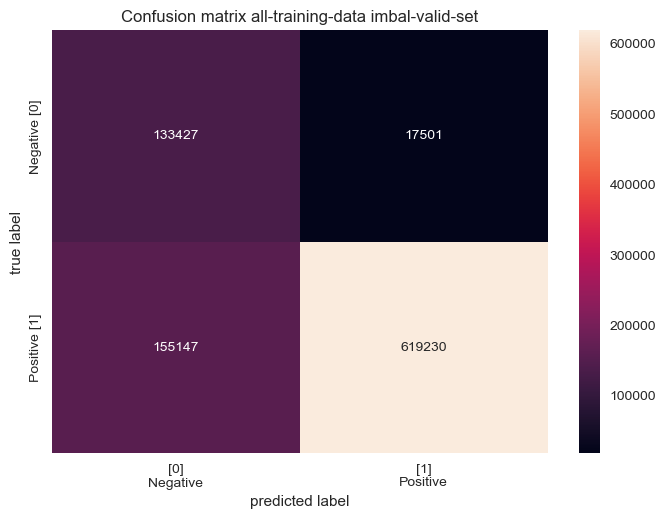

In [70]:
create_confusion_matrix_graph(y_imbal_valid, y_imbal_valid_pred, 'Confusion matrix all-training-data imbal-valid-set', save=False)

0.4250963917786909


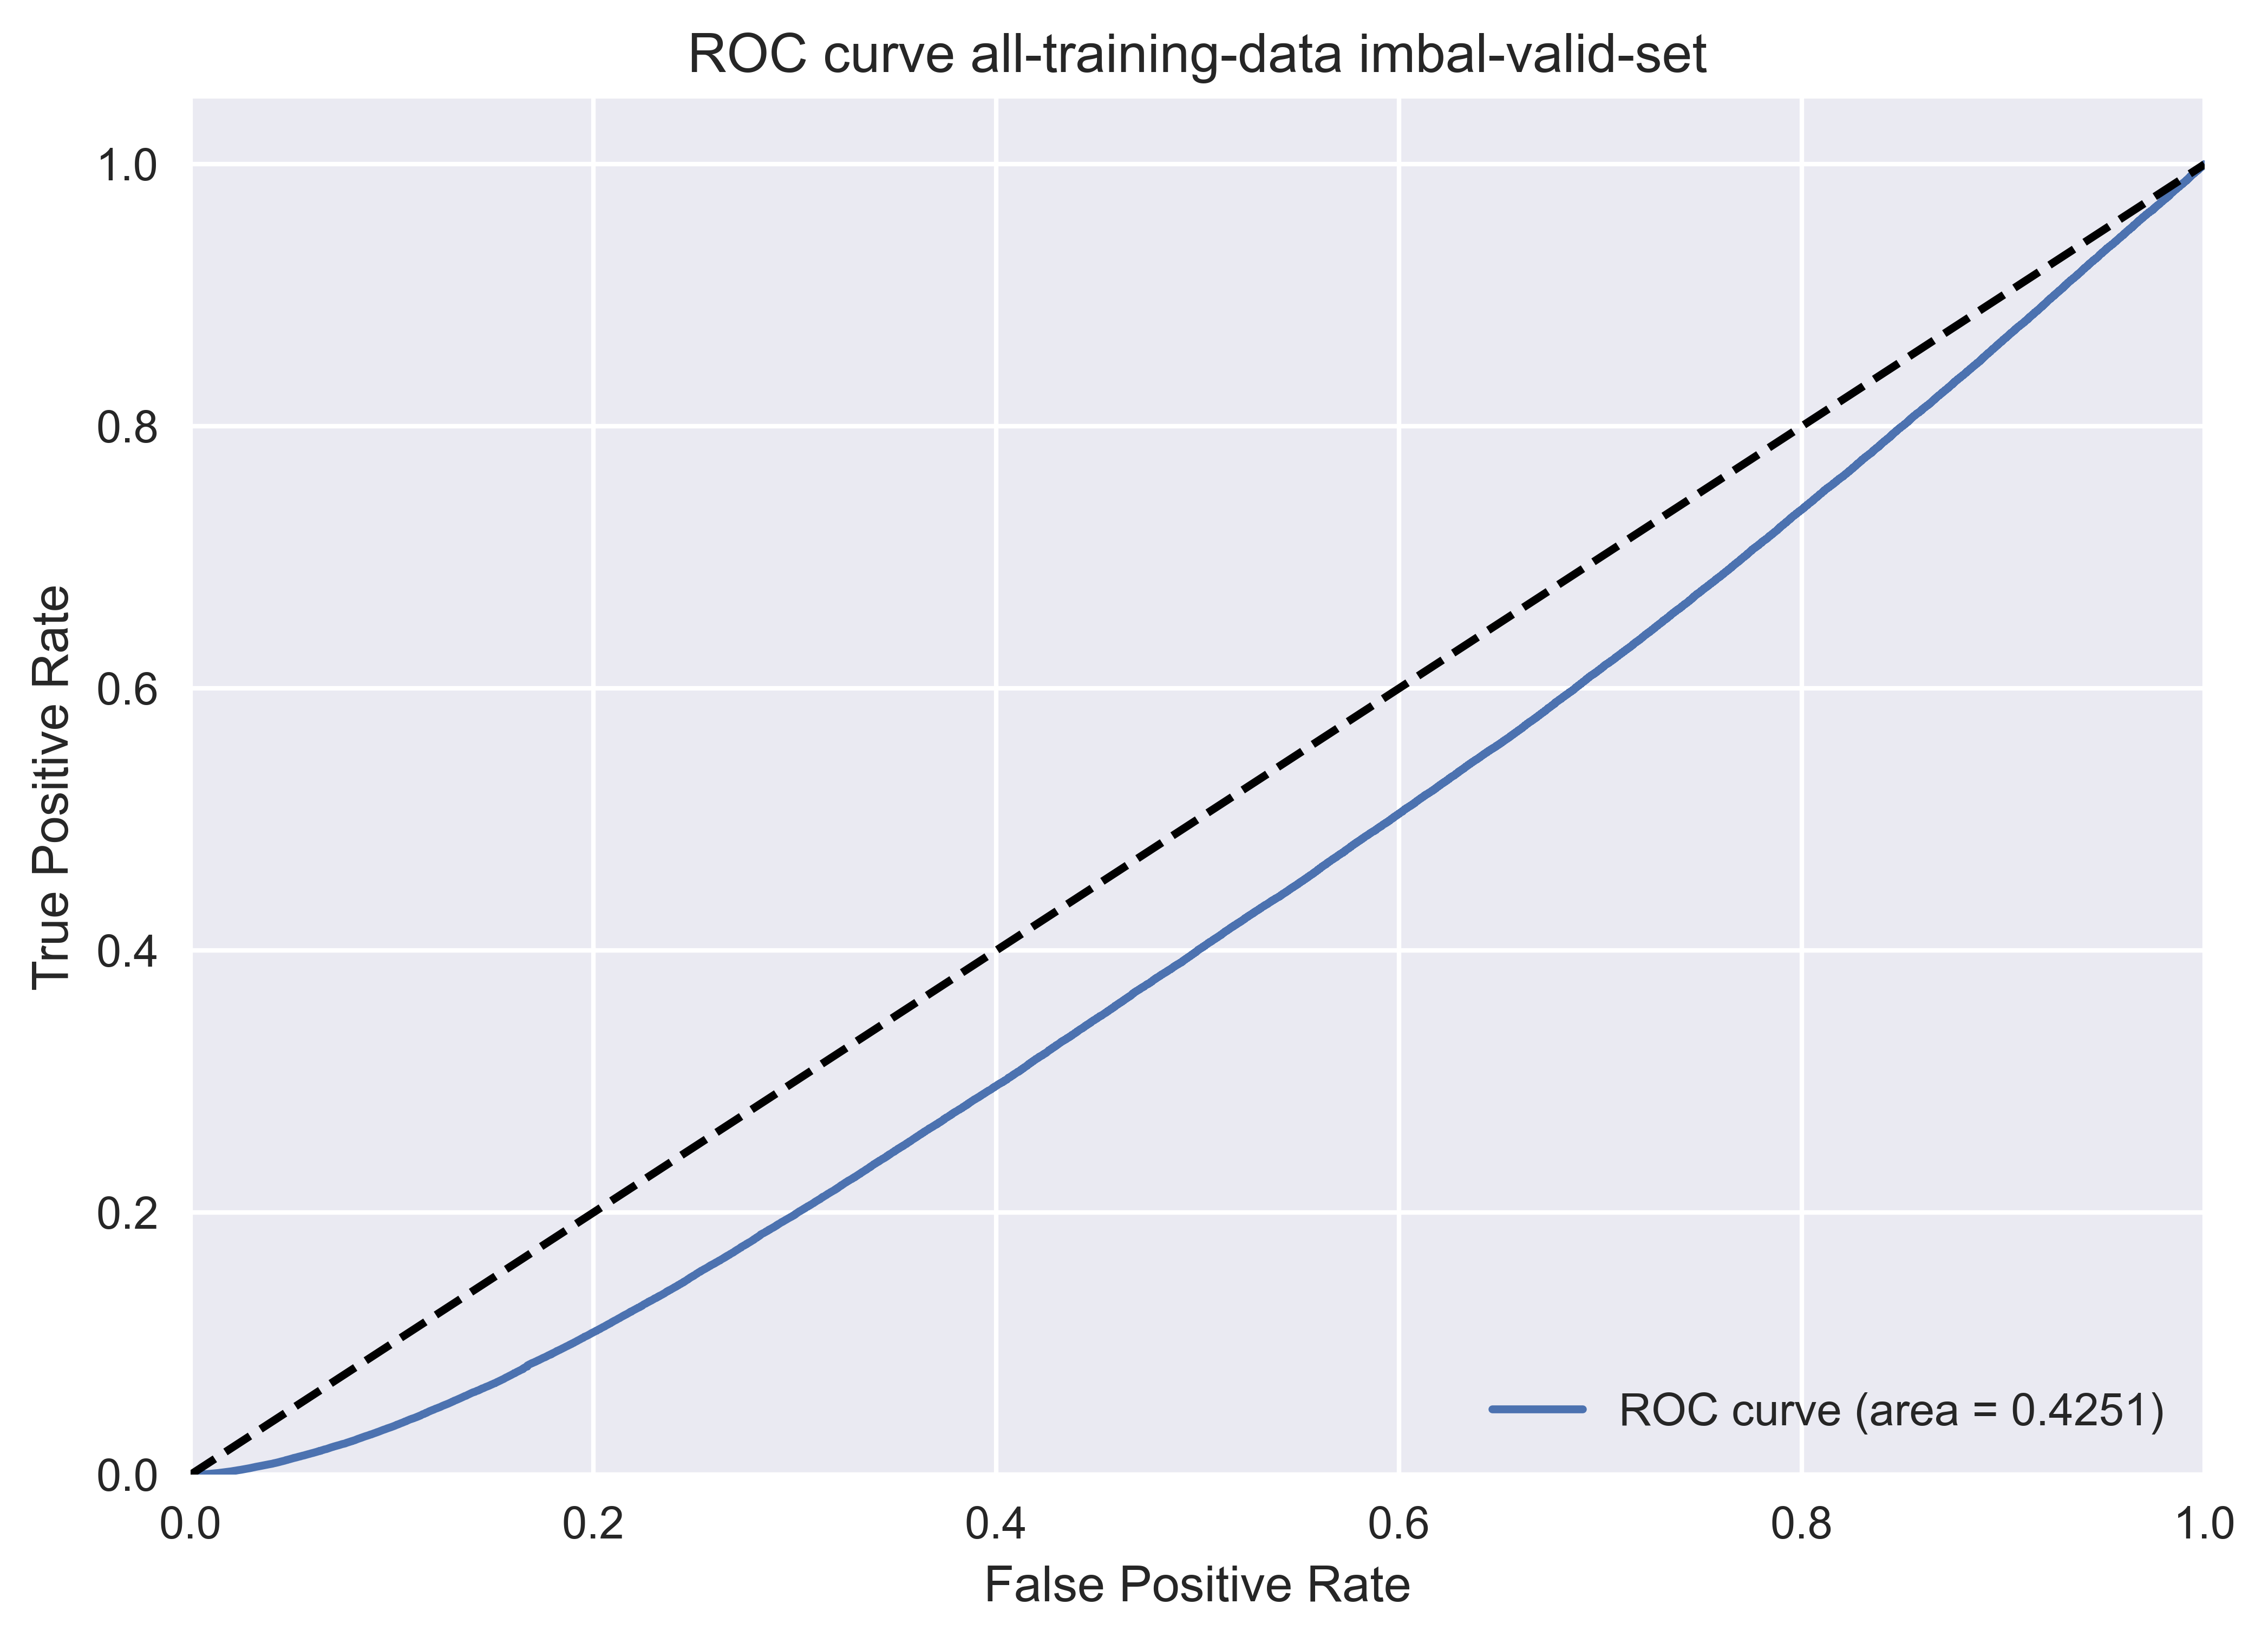

In [71]:
plot_roc_curve_binary(y_imbal_valid, y_imbal_valid_pred_prob, title='ROC curve all-training-data imbal-valid-set', save=False)

on fixed balanced validation set

In [72]:
y_bal_valid_pred_prob_raw = model.predict(valid_bal_dataset)

y_bal_valid_pred = np.argmax(y_bal_valid_pred_prob_raw, axis=1)

y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])

   1/2355 [..............................] - ETA: 1:24

2355/2355 [==============================] - 12s 5ms/step


In [73]:
print_classification_report(y_bal_valid, y_bal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.88      0.85    150672
           1       0.87      0.80      0.83    150672

    accuracy                           0.84    301344
   macro avg       0.84      0.84      0.84    301344
weighted avg       0.84      0.84      0.84    301344



TN - True Negative 133196
FN - False Negative 30323
TP - True Positive 120349
FP - False Positive 17476
Accuracy Rate: 0.8413806148454922
Misclassification Rate: 0.1586193851545078
F1-Score: 0.8410917965713895
ROC-AUC 0.8413806148454922


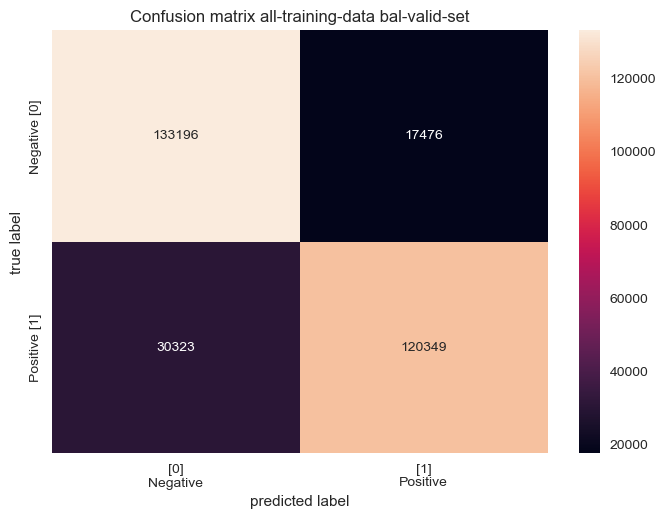

In [74]:
create_confusion_matrix_graph(y_bal_valid, y_bal_valid_pred, 'Confusion matrix all-training-data bal-valid-set', save=False)

0.42247391543060286


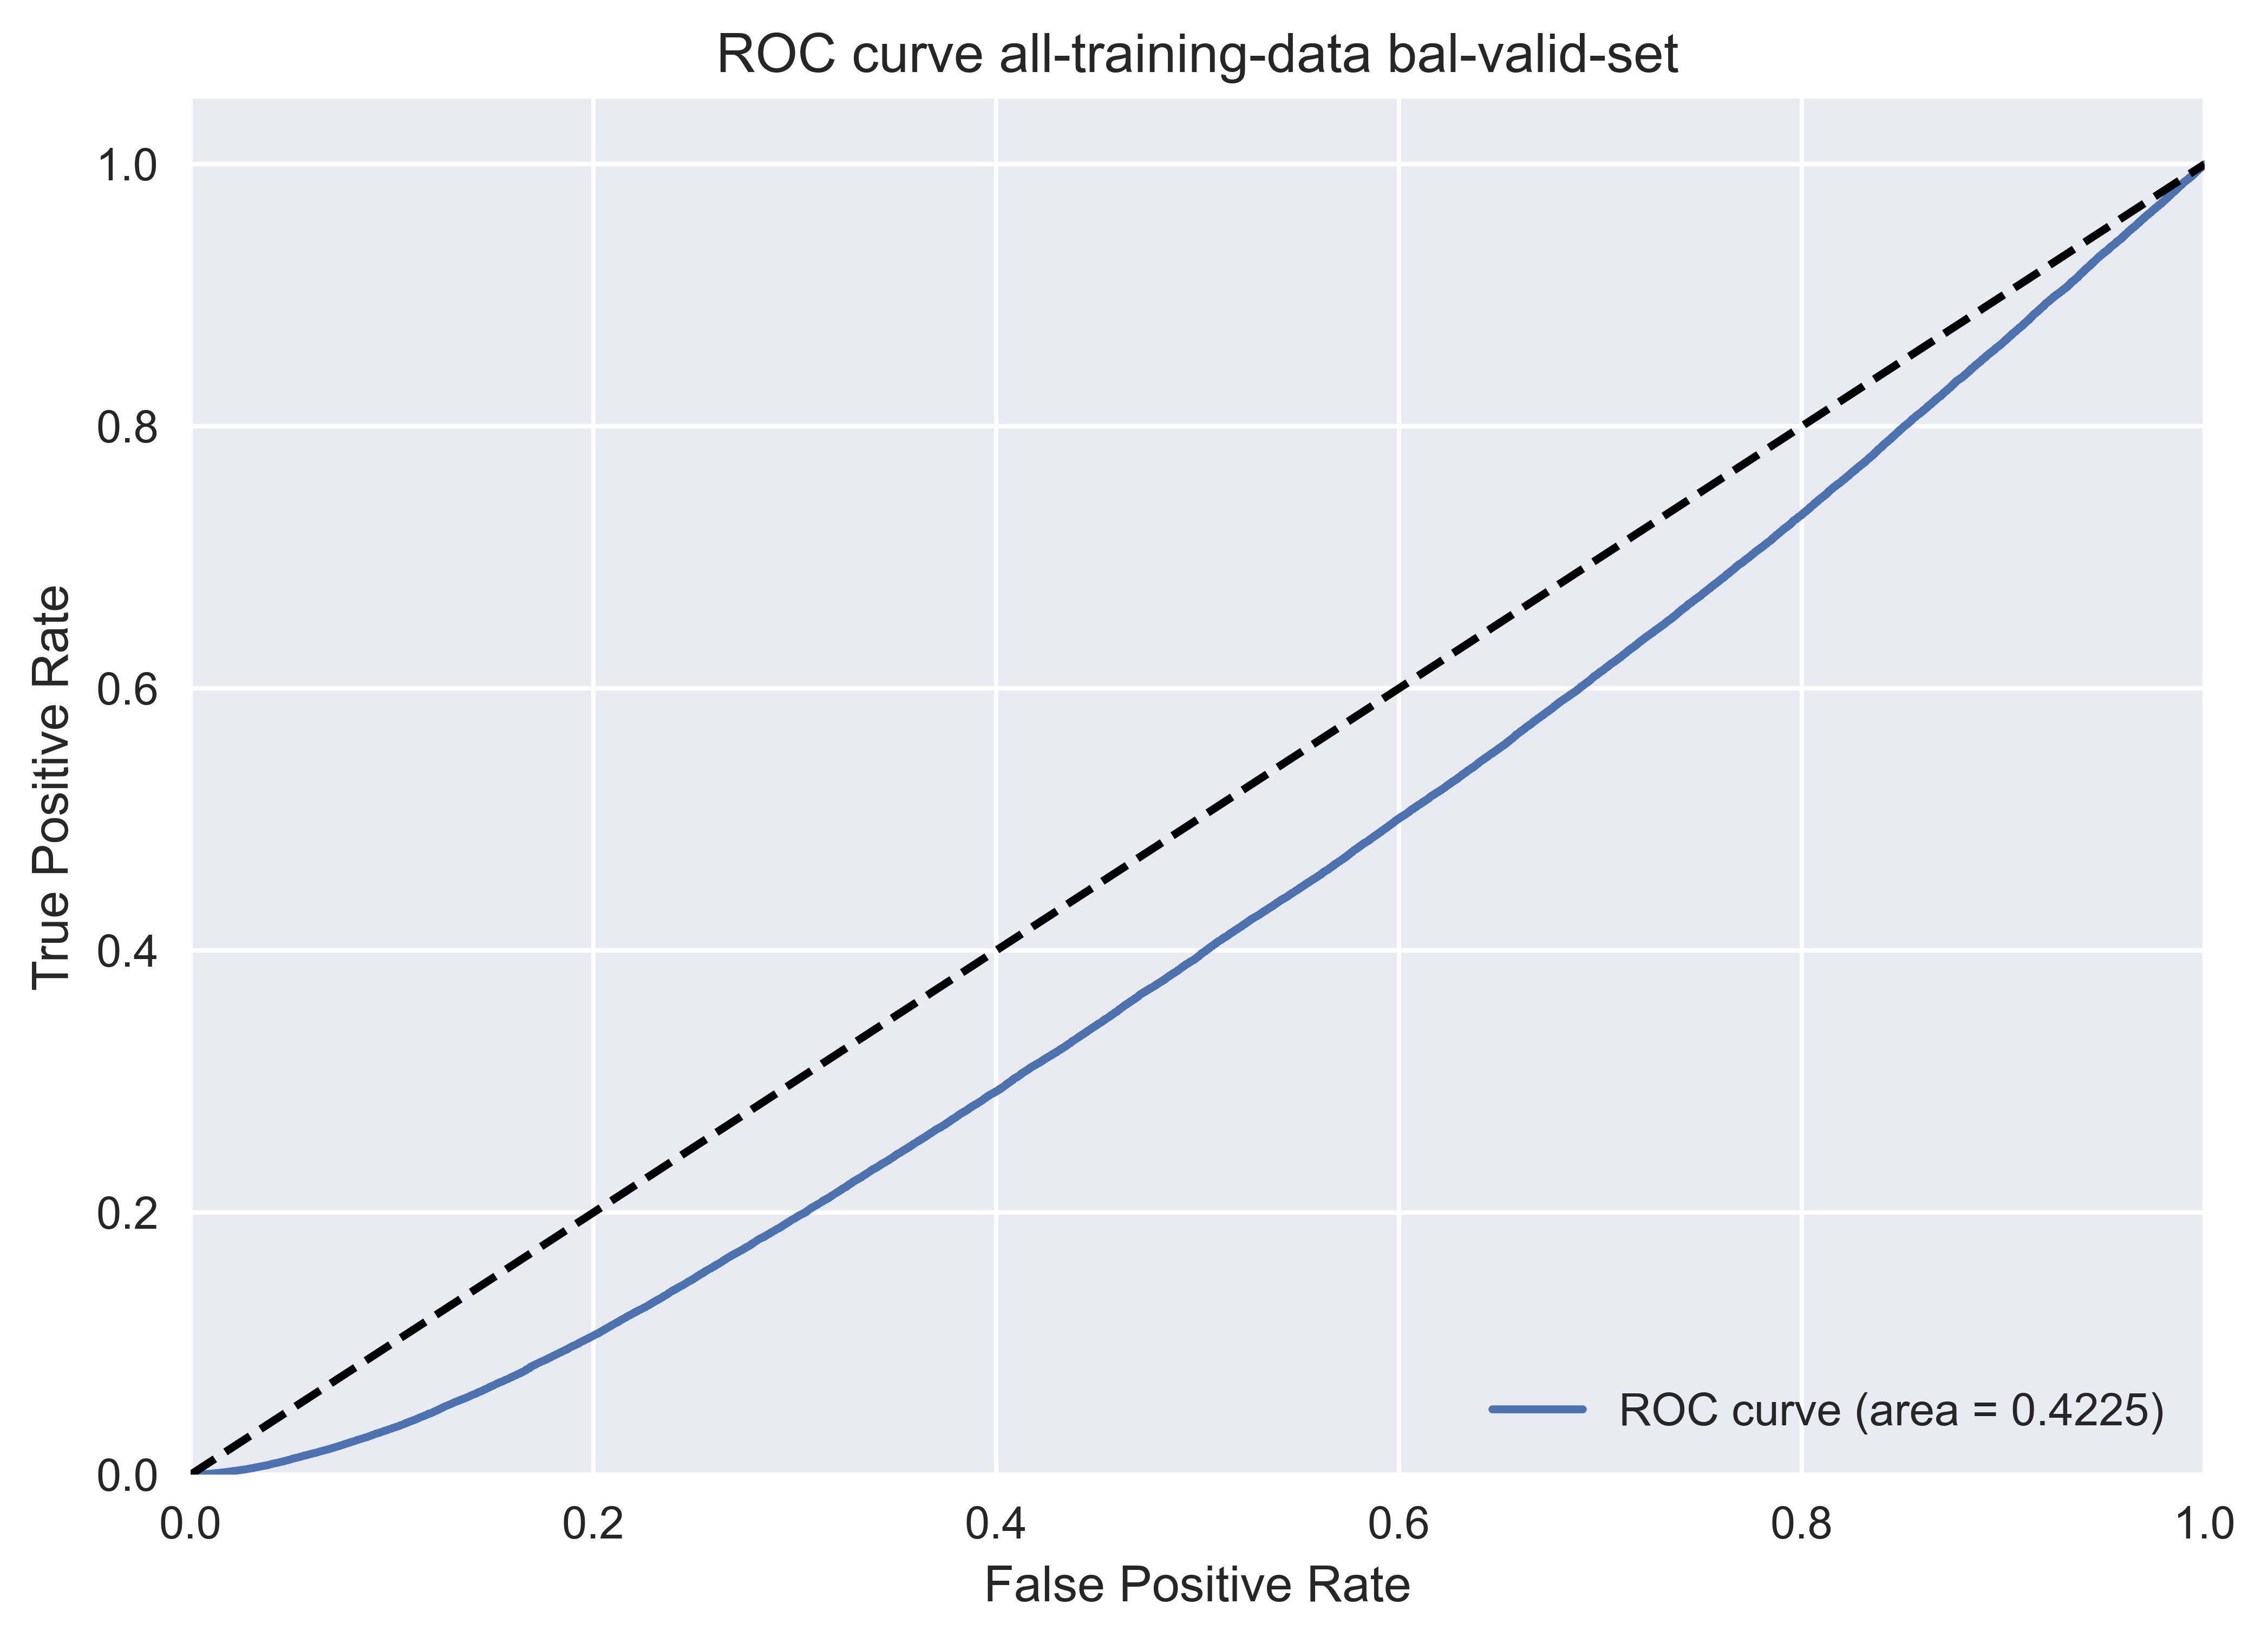

In [75]:
plot_roc_curve_binary(y_bal_valid, y_bal_valid_pred_prob, title='ROC curve all-training-data bal-valid-set', save=False)